## 001_simple_v1

This run uses a very simple model to get a rough idea for how difficult the problem is.

In [6]:
import sys
sys.path.append('../')
sys.path.append('../../../')
# keras expects data to be encoded in a particular way, to_categorical does this encoding for us (one-hot encoding)
from keras.utils.np_utils import to_categorical
import libs.importing as importing
import pandas as pd
import os
import libs.render as render
import libs.cnn_models as cnn_models
import libs.analysis as analysis
import libs.normalization as normalization
from importlib import reload
import libs.data_prep as data_prep
import numpy as np

from pylab import rcParams
rcParams['figure.figsize'] = (10,8)

In [12]:
# LOAD PATCH DATA REFERENCES

# directory setup
data_source = '../41157150'
train_dir = os.path.join(data_source, 'train')
test_dir = os.path.join(data_source, 'test')
val_dir = os.path.join(data_source, 'val')

# get references to the data we want
train_patches_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned_shuffled.csv'))
train_data_reader = importing.PatchDataReader(os.path.join(train_dir, 'patches'), train_patches_df)

test_patches_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned_shuffled.csv'))
test_data_reader = importing.PatchDataReader(os.path.join(test_dir, 'patches'), test_patches_df)

val_patches_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned_shuffled.csv'))
val_data_reader = importing.PatchDataReader(os.path.join(val_dir, 'patches'), val_patches_df)

In [13]:
## READ PATCH DATA

# load train, test, and validation data
x_train, y_train = train_data_reader.read_data()
x_test, y_test = test_data_reader.read_data()
x_val, y_val = val_data_reader.read_data()

# LOG RESULTS
## Visualize the patches
data_prep.log_patch_data_reader(train_dir, train_data_reader)
data_prep.log_patch_data_reader(test_dir, test_data_reader)
data_prep.log_patch_data_reader(val_dir, val_data_reader)

In [14]:
## CONVERT CLASSES TO KERAS FORMAT
# keras expects classes to be number from 0-N, we are using 1-N numbering so we need to convert.
# then we also have to change the classes to one-hot encoding

y_train_oh = to_categorical(y_train - 1)
y_test_oh  = to_categorical(y_test - 1)
y_val_oh   = to_categorical(y_val - 1)

In [15]:
# NORMALIZATION

m, std = normalization.dataset_mean_and_std(x_train)

x_train = (x_train - m) / std
x_test  = (x_test - m) / std
x_val   = (x_val - m) / std

In [16]:
## MODEL : load from file, show summary, and compile
reload(cnn_models)

model = cnn_models.model_simple_v1_2class()
display(model.summary())

# parameters:
learning_rate = 1e-3

model.compile(optimizer = 'adam', loss = "binary_crossentropy", metrics=["accuracy"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 64)        0         
__________

None

In [17]:
data_prep.check_for_nans(x_train)
data_prep.check_for_nans(x_test)
data_prep.check_for_nans(x_val)

print(y_train[:100], y_test[:100], y_val[:100])

[2 2 2 2 2 2 2 1 2 2 2 2 2 1 1 2 1 2 1 1 2 2 2 2 1 2 1 2 2 2 1 2 1 2 1 2 2
 2 1 2 2 2 1 1 2 2 2 2 2 2 1 1 2 2 2 1 2 1 2 2 1 1 2 2 2 2 1 2 2 2 2 1 2 2
 2 2 2 2 2 2 2 2 1 1 1 2 2 2 2 1 2 2 2 2 1 2 2 1 2 2] [1 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 1 1 2 2 2 1 1 1 2 2 2 2
 1 1 1 2 1 1 2 1 1 1 1 2 1 1 2 2 2 2 2 1 1 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 1
 1 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 1 1 1 2 2 2 2 2 2] [1 2 2 2 1 2 1 2 2 2 2 1 2 1 2 2 2 1 1 1 2 2 2 2 1 2 2 1 2 2 2 2 1 2 2 1 1
 1 1 1 1 2 1 2 2 2 1 2 1 1 2 2 2 1 1 2 1 2 2 2 1 2 2 2 1 1 2 1 2 2 1 1 2 1
 2 2 2 1 2 1 1 1 2 2 2 1 2 1 1 2 2 1 1 1 2 1 2 1 2 2]


In [19]:
## RUN!!!

# parameters
batch_size = 16
epochs = 10

history = model.fit(x_train,y_train_oh, batch_size=batch_size,
                              epochs = epochs,
                              validation_data = (x_test,y_test_oh), shuffle=True,
                              verbose = 1, callbacks=[cnn_models.annealer()])

Train on 2812 samples, validate on 346 samples
Epoch 1/10
2812/2812 [==============================] - 42s 15ms/step - loss: 0.2735 - acc: 0.8969 - val_loss: 0.6081 - val_acc: 0.8988
Epoch 2/10
2812/2812 [==============================] - 5s 2ms/step - loss: 0.1971 - acc: 0.9257 - val_loss: 0.9105 - val_acc: 0.8887
Epoch 3/10
2812/2812 [==============================] - 5s 2ms/step - loss: 0.1927 - acc: 0.9285 - val_loss: 0.8044 - val_acc: 0.8931
Epoch 4/10
2812/2812 [==============================] - 5s 2ms/step - loss: 0.1864 - acc: 0.9326 - val_loss: 1.2999 - val_acc: 0.8858
Epoch 5/10
2812/2812 [==============================] - 5s 2ms/step - loss: 0.1680 - acc: 0.9379 - val_loss: 0.9991 - val_acc: 0.8902

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/10
2812/2812 [==============================] - 5s 2ms/step - loss: 0.1393 - acc: 0.9458 - val_loss: 1.1762 - val_acc: 0.8786
Epoch 7/10
2812/2812 [==============================] - 5s 2ms/ste

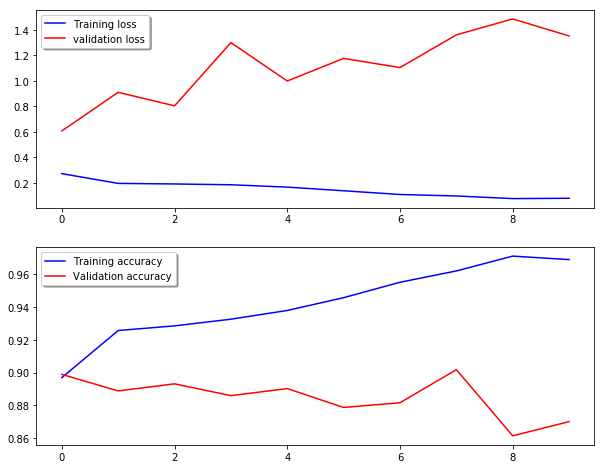

Precision (specificity): 72.713%
Recall (sensitivity): 72.134%
Accuracy: 71.944%
F1: 71.808%


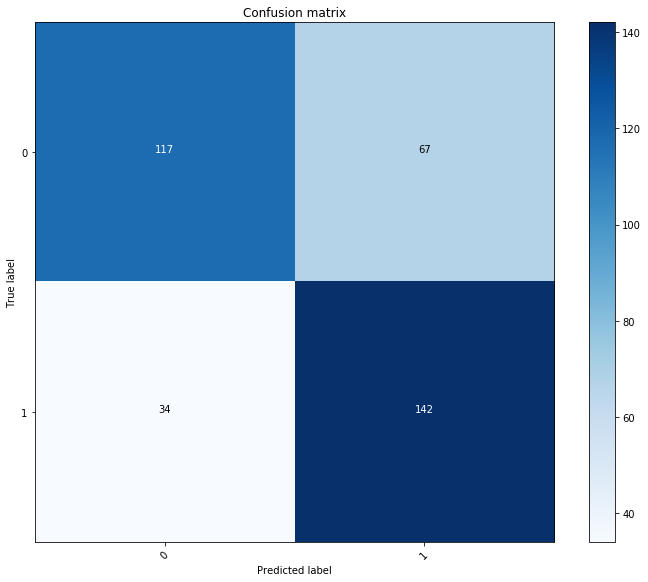

In [21]:
render.plot_training_and_validation_curves(history)
y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [24]:
## CONTOUR LEVEL ANALYSIS
reload(analysis)

analysis.plot_contour_predictions(test_data_reader, model, test_dir, norm_data=(m, std))
analysis.contour_statistics(test_data_reader, model, test_dir, norm_data=(m, std))

mdi-b731a91f [0.00142678 0.9989222 ] 1
hgv-2d4a6a46 [0.87023705 0.13693188] 0
mdi-5e3d3832 [0.0172608 0.9886071] 1
hgv-ff91c0a9 [0.8754573  0.12522279] 0
mdi-e3b0c312 [3.336396e-04 9.998087e-01] 0
odi-1767f1a2 [0.16310947 0.82270026] 1


In [ ]:
model.save('model_001_no_reg.h5')